# lifelines - predictive maintenance

## Importing the libraries

In [467]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [468]:
# pyspark_df = spark.table("sd_bdc_demo.sarima_time_series_forecasting.1_service_now_survival_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [469]:
df = pd.read_csv("2_maintenance_updated_data/2_maintenance_updated_data.csv")


In [470]:
print(df.head())

   Observation_Index  Asset_Number  lifetime  broken  pressureInd  \
0                  0        100080        56       0           92   
1                  1        100080        63       0          116   
2                  2        100080        10       0          114   
3                  3        100080        60       1          120   
4                  4        100080        45       0          146   

   moistureInd  temperatureInd  provider_Provider2  provider_Provider3  \
0          104              96                   0                   0   
1           99              47                   0                   0   
2          112              76                   0                   1   
3           93             114                   0                   1   
4           98             106                   0                   0   

   provider_Provider4  team_TeamB  team_TeamC  
0                   1           0           0  
1                   0           1           

In [471]:
print(df.columns)

Index(['Observation_Index', 'Asset_Number', 'lifetime', 'broken',
       'pressureInd', 'moistureInd', 'temperatureInd', 'provider_Provider2',
       'provider_Provider3', 'provider_Provider4', 'team_TeamB', 'team_TeamC'],
      dtype='object')


In [472]:
print(df.dtypes)

Observation_Index     int64
Asset_Number          int64
lifetime              int64
broken                int64
pressureInd           int64
moistureInd           int64
temperatureInd        int64
provider_Provider2    int64
provider_Provider3    int64
provider_Provider4    int64
team_TeamB            int64
team_TeamC            int64
dtype: object


In [473]:
print(df.shape)

(1000, 12)


### Columns to drop

In [474]:
df.drop(columns=['Observation_Index', 'Asset_Number'], errors='ignore', inplace=True)

In [475]:
print(df.shape)

(1000, 10)


## Train Test split

In [476]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

## The Weibull AFT model

In [477]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()
training_timestamp = datetime.now().strftime("%m/%d/%Y %H:%M")
print(training_timestamp)
aft.fit(df_train, duration_col='lifetime', event_col='broken')

06/24/2025 17:23


<lifelines.WeibullAFTFitter: fitted with 800 total observations, 474 right-censored observations>

In [478]:
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 800 total observations, 474 right-censored observations>
             duration col = 'lifetime'
                event col = 'broken'
   number of observations = 800
number of events observed = 326
           log-likelihood = -40.87
         time fit was run = 2025-06-24 11:53:50 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                           
lambda_ moistureInd         0.00      1.00      0.00            0.00            0.00                1.00                1.00
        pressureInd        -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        provider_Provider2  0.15      1.16      0.00            0.15            0.15                1.16                1.16
        provider_Provider3 -0.20      0.82      0.00           -0.20           -0.20                0.82                0.82
        provider_Provider4  0.10      1.10      0.00            0.10            0.10                1.10                1.10
        team_TeamB         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        team_TeamC         -0.08      0.92      0.00           -0.08           -0.08                0.92                0.92
        temperatureInd     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        Intercept           4.39     80.72      0.00            4.39            4.40               80.35               81.08
rho_    Intercept           5.77    319.10      0.04            5.68            5.85              294.10              346.23

                            cmp to       z      p  -log2(p)
param   covariate                                          
lambda_ moistureInd           0.00    5.49 <0.005     24.59
        pressureInd           0.00   -2.11   0.04      4.83
        provider_Provider2    0.00  309.54 <0.005       inf
        provider_Provider3    0.00 -440.55 <0.005       inf
        provider_Provider4    0.00  183.06 <0.005       inf
        team_TeamB            0.00   -2.07   0.04      4.68
        team_TeamC            0.00 -180.19 <0.005       inf
        temperatureInd        0.00  -21.15 <0.005    327.50
        Intercept             0.00 1910.52 <0.005       inf
rho_    Intercept             0.00  138.49 <0.005       inf
---
Concordance = 1.00
AIC = 101.74
log-likelihood ratio test = 2454.26 on 8 df
-log2(p) of ll-ratio test = inf

In [479]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)

79.87084564660978
79.81876822574553


### Saving summary table

In [480]:
summary_df = aft.summary.copy()
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={"index": "Parameter"})



In [481]:
# Create the folder if it doesn't exist
os.makedirs("3_1_maintenance_aft_model_train_summary_data", exist_ok=True)

# Save the Excel file inside the folder
summary_df.to_csv("3_1_maintenance_aft_model_train_summary_data/3_1_maintenance_aft_model_train_summary_data.csv", index=False)

### Saving meta data

In [482]:
meta_info = {
    "Model": str(type(aft)),
    "Duration column": 'lifetime',
    "Event column": 'broken',
    "Number of observations": df_train.shape[0],
    "Number of events observed": df_train['broken'].sum(),
    "Log-likelihood": aft.log_likelihood_,
    "Concordance": aft.concordance_index_,
    "AIC": aft.AIC_,
    "LLR test": aft.log_likelihood_ratio_test().test_statistic,
    "LLR df_train": aft.log_likelihood_ratio_test().degrees_freedom,
    "-log2(p) of LLR": -np.log2(aft.log_likelihood_ratio_test().p_value)
}

# Convert to DataFrame
meta_df = pd.DataFrame(list(meta_info.items()), columns=["Metric", "Value"])

C:\Users\LakshmanNavaneethakr\AppData\Local\Temp\ipykernel_23568\2825586005.py:12: RuntimeWarning: divide by zero encountered in log2
  "-log2(p) of LLR": -np.log2(aft.log_likelihood_ratio_test().p_value)


In [483]:
# Create the folder if it doesn't exist
os.makedirs("3_2_maintenance_aft_model_train_meta_data", exist_ok=True)

# Save the Excel file inside the folder
meta_df.to_csv("3_2_maintenance_aft_model_train_meta_data/3_2_maintenance_aft_model_train_meta_data.csv", index=False)

## Plotting

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

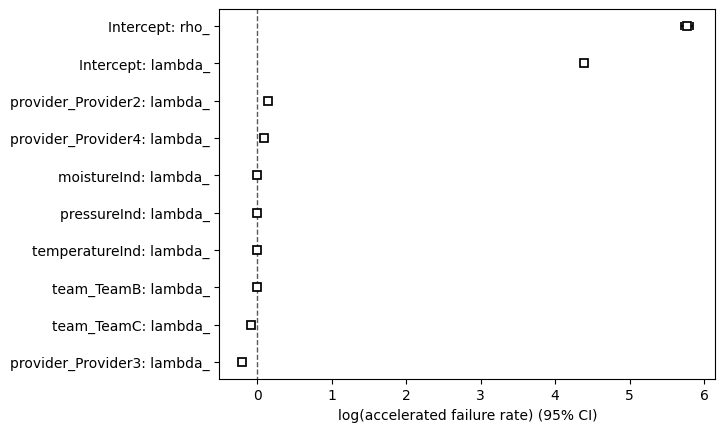

In [484]:
from matplotlib import pyplot as plt

aft.plot()

### Survival Function curve on all row

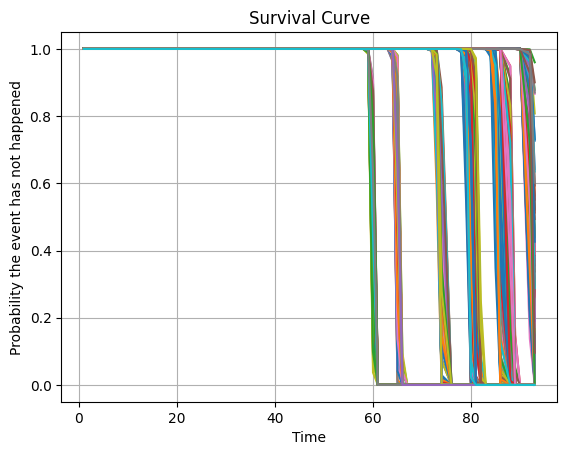

In [485]:
import matplotlib.pyplot as plt

# Curve for all rows
row = df_train

# Predict and plot survival curve
S = aft.predict_survival_function(row)
ax = S.plot()
ax.set_title("Survival Curve")
ax.set_xlabel("Time")
ax.set_ylabel("Probability the event has not happened")
ax.grid(True)
ax.get_legend().remove()
plt.show()


### Survival Function curve on 0th row

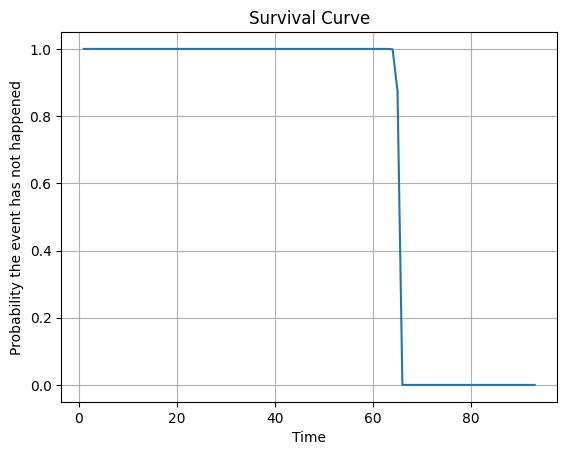

In [486]:
# Curve for 0th row
row = df_train.iloc[[0]]

# Predict and plot survival curve
S = aft.predict_survival_function(row)
ax = S.plot()
ax.set_title("Survival Curve")
ax.set_xlabel("Time")
ax.set_ylabel("Probability the event has not happened")
ax.grid(True)
ax.get_legend().remove()
plt.show()

## Prediction
| Method                         | Meaning                                                                | Suitable for "next likely event"?                                 |
| ------------------------------ | ---------------------------------------------------------------------- | ----------------------------------------------------------------- |
| `predict_median(X)`            | **Time at which there’s a 50% chance** the subject will have the event | ✅ Yes — this is the best estimate                                 |
| `predict_percentile(X, p=0.9)` | Time when **90% chance of event** has occurred                         | ❌ No — this is more pessimistic                                   |
| `predict_expectation(X)`       | **Average** (expected) time to event                                   | ✅ Optional — but less robust due to sensitivity to extreme values |


In [487]:
aft.predict_cumulative_hazard(df_test)

,521,737,740,660,411,678,626,513,859,136,...,948,829,656,199,213,408,332,208,613,78
1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88.0,6.151971e+24,1.075283e+52,1.324916e+04,3.416228e+41,1.651948e-07,2.986392e-07,1.282032e+04,7.223009e-01,3.517986e+41,4.190327e-01,...,2.156807e+10,1.733050e+00,1.574211e-01,2.390716e+00,1.526812e+03,4.285335e+02,1.292916e+52,8.342776e+41,1.240398e-07,3.840817e+13
89.0,2.264421e+26,3.957907e+53,4.876760e+05,1.257448e+43,6.080499e-06,1.099233e-05,4.718913e+05,2.658650e+01,1.294902e+43,1.542378e+01,...,7.938790e+11,6.379019e+01,5.794364e+00,8.799761e+01,5.619899e+04,1.577349e+04,4.758973e+53,3.070814e+43,4.565664e-06,1.413730e+15
90.0,8.005773e+27,1.399303e+55,1.724159e+07,4.445656e+44,2.149737e-04,3.886295e-04,1.668353e+07,9.399552e+02,4.578076e+44,5.453017e+02,...,2.806728e+13,2.255277e+03,2.048575e+02,3.111121e+03,1.986893e+06,5.576655e+05,1.682516e+55,1.085674e+45,1.614173e-04,4.998188e+16
92.0,8.898945e+30,1.555417e+58,1.916517e+10,4.941641e+47,2.389574e-01,4.319874e-01,1.854485e+10,1.044822e+06,5.088834e+47,6.061389e+05,...,3.119864e+16,2.506890e+06,2.277126e+05,3.458217e+06,2.208563e+09,6.198821e+08,1.870228e+58,1.206799e+48,1.794259e-01,5.555816e+19


In [488]:
aft.predict_survival_function(df_test)

,521,737,740,660,411,678,626,513,859,136,...,948,829,656,199,213,408,332,208,613,78
1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,...,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.0,1.0,1.000000,1.0
2.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,...,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.0,1.0,1.000000,1.0
3.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,...,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.0,1.0,1.000000,1.0
4.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,...,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.0,1.0,1.000000,1.0
5.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,...,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.0,1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,4.856336e-01,0.0,6.576827e-01,...,0.0,1.767446e-01,8.543443e-01,9.156412e-02,0.0,7.767076e-187,0.0,0.0,1.000000,0.0
89.0,0.0,0.0,0.0,0.0,0.999994,0.999989,0.0,2.842043e-12,0.0,2.002336e-07,...,0.0,1.978201e-28,3.044666e-03,6.069066e-39,0.0,0.000000e+00,0.0,0.0,0.999995,0.0
90.0,0.0,0.0,0.0,0.0,0.999785,0.999611,0.0,0.000000e+00,0.0,1.508221e-237,...,0.0,0.000000e+00,1.075307e-89,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.999839,0.0
92.0,0.0,0.0,0.0,0.0,0.787448,0.649218,0.0,0.000000e+00,0.0,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.835750,0.0


In [489]:
aft.predict_median(df_test)

521    73.502196
737    60.384858
740    85.322935
660    65.136810
411    92.307549
         ...    
408    86.245366
332    60.349989
208    64.954810
613    92.390469
78     79.691709
Length: 200, dtype: float64

In [490]:
aft.predict_percentile(df_test, p=0.9)

521    73.069547
737    60.029420
740    84.820706
660    64.753402
411    91.764208
         ...    
408    85.737707
332    59.994757
208    64.572473
613    91.846640
78     79.222626
Length: 200, dtype: float64

In [491]:
aft.predict_expectation(df_test)

521    73.454272
737    60.345486
740    85.267302
660    65.094340
411    92.247363
         ...    
408    86.189132
332    60.310640
208    64.912459
613    92.330229
78     79.639748
Length: 200, dtype: float64

## Save the table

In [492]:
predicted_median = aft.predict_median(df_test)

# Step 2: Combine the actual and predicted into one DataFrame
result_df = pd.DataFrame({
    "index": df_test.index,
    "actual_lifetime": df_test["lifetime"].values,
    "actual_event": df_test["broken"].values,
    "predicted_median_time": predicted_median.values
})

result_df.reset_index(drop=True, inplace=True)



In [493]:
# Create the folder if it doesn't exist
os.makedirs("3_3_maintenance_aft_predicted_data", exist_ok=True)

# Save the Excel file inside the folder
result_df.to_csv("3_3_maintenance_aft_predicted_data/3_3_maintenance_aft_predicted_data.csv", index=False)

## Saving regression Evaluation Metrics

In [494]:
mask_event_1 = df_test["broken"] == 1
actual_lifetime = df_test.loc[mask_event_1, "lifetime"]
X_event_1 = df_test.loc[mask_event_1]


In [495]:
predicted_lifetime_event_1 = aft.predict_median(X_event_1)


In [496]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

r2 = r2_score(actual_lifetime, predicted_lifetime_event_1)
mae = mean_absolute_error(actual_lifetime, predicted_lifetime_event_1)
rmse = np.sqrt(mean_squared_error(actual_lifetime, predicted_lifetime_event_1))
mape = mean_absolute_percentage_error(actual_lifetime, predicted_lifetime_event_1)
Accuracy = 100 - (mape*100)


In [497]:
# Model Run Id
model_type_abbr = "waft"
project_name = "predictive_maintenance"
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
model_run_id = f"{model_type_abbr}_{project_name}_{timestamp_str}"

# Model Type
model_type = "WeibullAFTFitter"

# model version 
version_file = "3_4_maintenance_aft_metrics_data.csv"
if os.path.exists(version_file):
    versions_df = pd.read_csv(version_file)
    max_version = versions_df[versions_df["model_type"] == model_type]["model_version"].max()
    model_version = int(max_version) + 1
else:
    model_version = 1

# training_timestamp
training_timestamp = training_timestamp

# dataset size
dataset_size = df_test.shape[0]

# feature count
feature_count = df_test.shape[1] 

# ==== Create metrics DataFrame ====
metrics_df = pd.DataFrame([{
    "model_run_id": model_run_id,
    "model_type": model_type,
    "model_version": model_version,
    "training_timestamp": training_timestamp,
    "dataset_size": dataset_size,
    "feature_count": feature_count,
    "regression_accuracy": Accuracy,
    "r2": r2,
    "mae": mae,
    "rmse": rmse,
    "mape": mape
}])




In [498]:
# # Create the folder if it doesn't exist
# os.makedirs("3_4_maintenance_aft_metrics_data", exist_ok=True)

# # Save the Excel file inside the folder
# metrics_df.to_csv("3_4_maintenance_aft_metrics_data/3_4_maintenance_aft_metrics_data.csv", index=False)


In [499]:
# Directory & file path
folder = "3_4_maintenance_aft_metrics_data"
os.makedirs(folder, exist_ok=True)

# Full path to the CSV file
version_file = os.path.join(folder, "3_4_maintenance_aft_metrics_data.csv")

# Append the full metrics row to the CSV log (create file if it doesn't exist)
metrics_df.to_csv(
    version_file,
    mode='a',
    header=not os.path.exists(version_file),
    index=False
)